In [5]:
from data_loader import load_classifier_data
from classifier_models import CNN_Classifier
from classifier_models import UNET_Classifier
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False # Metal API for MacOS

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device {DEVICE}")

# load dataset
(trainX, trainy), (testX, testy) = load_classifier_data(DEVICE)

model = UNET_Classifier().to(DEVICE)
model.load_state_dict(torch.load("./data/state_dict_model.pt"), strict=True)
model.eval()

print(model)


Using device cuda
UNET_Classifier(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): UNETAttentionBlock(
    (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
    (conv_input): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (layernorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (self_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (conv_output): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=6272, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)


Accuracy: 94.90%
Accuracy 0: 96 / 100 = 96.00%
Accuracy 1: 94 / 96 = 97.92%
Accuracy 2: 123 / 126 = 97.62%
Accuracy 3: 90 / 100 = 90.00%
Accuracy 4: 88 / 93 = 94.62%
Accuracy 5: 87 / 91 = 95.60%
Accuracy 6: 87 / 87 = 100.00%
Accuracy 7: 90 / 93 = 96.77%
Accuracy 8: 98 / 109 = 89.91%
Accuracy 9: 96 / 105 = 91.43%
Predicted: 3, target: 3 True
Predicted: 4, target: 4 True
Predicted: 4, target: 4 True
Predicted: 2, target: 2 True
Predicted: 9, target: 9 True
Predicted: 0, target: 0 True
Predicted: 6, target: 6 True
Predicted: 1, target: 1 True
Predicted: 2, target: 2 True


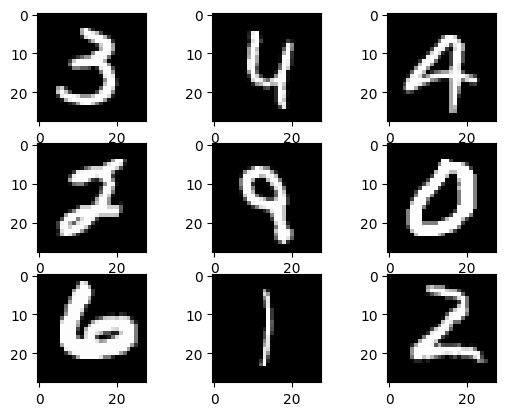

In [6]:
from matplotlib import pyplot as plt
import torchmetrics
import numpy as np

model.eval()

# demo batch
demo_batch_size = 1000
ri = np.random.permutation(testX.shape[0])[:demo_batch_size]
inputs, targets = testX[ri], testy[ri]

predictions = model(inputs)

# get accuracy
label_predictions = torch.argmax(predictions, dim=1)
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(DEVICE)
acc = accuracy(predictions, targets)
print(f"Accuracy: {acc * 100:.2f}%")

# get per-digit accuracy
correct = np.zeros(10)
total = np.zeros(10)
for i in range(demo_batch_size):
    #print(f"Predicted: {label_predictions[i]}, target: {targets[i]} {label_predictions[i] == targets[i]}")
    total[targets[i]] += 1
    correct[targets[i]] += (label_predictions[i] == targets[i])

digit_acc = correct / total * 100
for i in range(10):
    print(f"Accuracy {i}: {correct[i]:.0f} / {total[i]:.0f} = {digit_acc[i]:.2f}%")

# plot up to 9 images
for i in range(min(demo_batch_size, 9)):
    print(f"Predicted: {label_predictions[i]}, target: {targets[i]} {label_predictions[i] == targets[i]}")
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(inputs[i].squeeze().cpu(), cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Input: torch.Size([1, 1, 28, 28])
Pred: torch.Size([1, 10])
Label: tensor([3], device='cuda:0')
Label[0]: 3


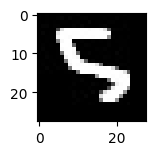

In [7]:
from data_loader import load_classifier_image

input_image_tensor = load_classifier_image("./data/digit.jpg", DEVICE)

pred = model(input_image_tensor)
label_pred = torch.argmax(pred, dim=1)

print(f"Input: {input_image_tensor.shape}")
print(f"Pred: {pred.shape}")
print(f"Label: {label_pred}")
print(f"Label[0]: {label_pred[0]}")

# define subplot
plt.subplot(330 + 1)
# plot raw pixel data
plt.imshow(input_image_tensor.squeeze().cpu(), cmap=plt.get_cmap('gray'))